# DNN_red_river tutorial example

## Problem description:

We would like to estimate red river profile using flow velocity measurements.

### Training Data:

#### synthetic river profiles:
We generate synthetic river profiles using the reference river profile:
1. Generate Gaussian noises with different length scales and different variances
2. Add the generated realizations to the reference profiles to generate new profiles 
3. use the **_AdH_** model for each river profile to generate the corresponding flow velocity profiles

    - These steps are not shown here because running AdH model is expensive. We load the generated data here.


Importing required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras import optimizers
from scipy.io import savemat, loadmat
from DNN_Net2 import DNN_Net2 as DNN_Net
from data_prep import river_data_prep as rdp
import timeit

Using TensorFlow backend.


Importing synthetic profiles and corresponding flow velocities

In [2]:
data = loadmat('data.mat')
prof_vel = data['vel']
prof_dep = data['depth']

Model parameters:

| Variable name     | Description                                                                       | Value     |
|  ---------------  |  -------------------------------------------------------------------------------  |  -------- |
| nx                | river grid size                                                                   | [501 41]  |
| size_dom          | The sampling box size (red box) for generating input and output sample            | [9 41]    |
| prof_vel          | numpy array containing velocity profiles for training network                     | prof_vel  |
| prof_dep          | numpy array containing river profiles for training network                        | prof_dep  |
| n_edge            | number of grid cells along the river for sampling data                            | 9         |
| divide_domain     | boolian variable for dividing the river profiles to two parts (seen, unseen)      | False     |
| mirror            | boolian variable to mirror the input profiles to generate more training profiles  | True      |
| shuffle           | boolian variable to shuffle the generated samples or not                          | True      |
| seed_num          | seed number to generate reproducible samples                                      | 101       |
| pca               | boolian variable to use pca approach or not                                       | True      |
| n_pc              | number of principle components (should be specified if pca is true)               | 41        |
| len_scale         | length scales for covariance matrix (should be determined if pca is true)         | [40 50]   |
| kernel            | covariance kernel type for pca method                                             | 'Gaussian'|



In [3]:
n_edge = 11
nx = [501, 41]
params_rdp = {'nx': nx, 'prof_vel': prof_vel, 'prof_dep': prof_dep,
              'n_edge': n_edge, 'shuffle': True, 'seed_num': 101, 'divide_domain': False, 'mirror': False,
              'pca': True, 'n_pc': 41, 'len_scale': [40, 50], 'kernel': 'Gaussian',
              'xmin': [0, 0], 'dx': [5, 5], 'size_dom': [n_edge, nx[1]]}


Initialize river_data_prep

In [4]:
model_data = rdp(params_rdp)

Generate training samples

In [5]:
X_train, Y_train = model_data.Gen_train_data()

Set DNN network parameters

In [6]:
param = {}
n_layer = 9
n_hidden = [900, 800, 800, 500, 400, 200, 100, 70, 41]
np.random.seed(101)
n_epoch_ = 30
#sgd = optimizers.SGD(lr=0.0006, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.00008, beta_1=0.9, beta_2=0.999, epsilon=None, decay=2e-6, amsgrad=False)

optimizer = adam


Train the network

In [7]:
start = timeit.default_timer()
network = DNN_Net(X_train, Y_train, n_layer, n_hidden, n_epoch=n_epoch_, Normalize=True, optimizer_meth=optimizer,
                  method='batchnorm', act_fcn='tanh', reg=0.01, batch_s=512)
run_time = timeit.default_timer() - start

Train on 88380 samples, validate on 22095 samples
Epoch 1/30
88380/88380 [==============================] - 22s 244us/step - loss: 32.0884 - mean_squared_error: 0.7437 - val_loss: 25.9784 - val_mean_squared_error: 0.6448
Epoch 2/30
88380/88380 [==============================] - 20s 227us/step - loss: 21.5726 - mean_squared_error: 0.5371 - val_loss: 17.8460 - val_mean_squared_error: 0.5424
Epoch 3/30
88380/88380 [==============================] - 19s 220us/step - loss: 15.0441 - mean_squared_error: 0.4565 - val_loss: 12.7072 - val_mean_squared_error: 0.5056
Epoch 4/30
88380/88380 [==============================] - 20s 228us/step - loss: 10.8421 - mean_squared_error: 0.4110 - val_loss: 9.3091 - val_mean_squared_error: 0.4443
Epoch 5/30
88380/88380 [==============================] - 20s 225us/step - loss: 8.0650 - mean_squared_error: 0.3811 - val_loss: 7.0470 - val_mean_squared_error: 0.4195
Epoch 6/30
88380/88380 [==============================] - 20s 226us/step - loss: 6.1715 - mean_squ

Variation of validation loss

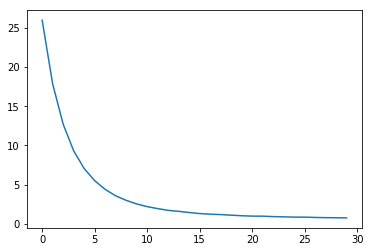

In [8]:
plt.plot(network.history.history['val_loss'])

Load test data

In [9]:
data_red_river = loadmat('red_river.mat')
vel_red = data_red_river['vel_ref']
prof_red = data_red_river['depth_ref']

Divide test data to input samples

In [10]:
X, Y = model_data.gen_test_data(vel=vel_red.reshape(-1, 1), dep=prof_red.reshape(-1, 1))

Make predictions for test input samples

In [11]:
bathy_dnn = network.predict(X)

Post process the outputs of network (the outputs are profile depth for small boxes or only the principle components for small boxes. So, they need to be processed to provide a single river profile)

In [12]:
pred_river = model_data.post_process(bathy_dnn)

Generate ensemble realizations

In [13]:
data = loadmat('A_Lx30_Ly10.mat')
A = data['A']
n_ens = 50
std = .1
realization = model_data.generate_realization(A, n_ens, std)


Make predictions for all ensemble members

In [14]:
results = np.zeros((len(pred_river.ravel()), n_ens))
for i in range(n_ens):
    X_r, Y_r = model_data.gen_test_data(vel=vel_red, dep=prof_red, noise=realization[:, i])
    bathy_ens = network.predict(X_r)
    results[:, i] = model_data.post_process(bathy_ens).ravel()


Compute prediction mean and standard deviation values

In [15]:
y_mean = np.mean(results, axis=1)
Y_diff = results - y_mean.reshape(-1, 1)
Post_Cov = np.dot(Y_diff, Y_diff.T)/(n_ens-1)
y_std = np.sqrt(np.diag(Post_Cov))


Plot 1D profiles for different lines along and across the river 

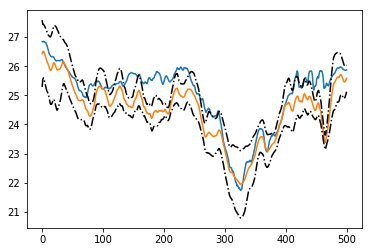

In [16]:
model_data.plot_1d(prof_red, pred_river, est_std=y_std, x=None, y=10, file_name='ens_1d.jpg', plt_show=False)

Estimated river profile

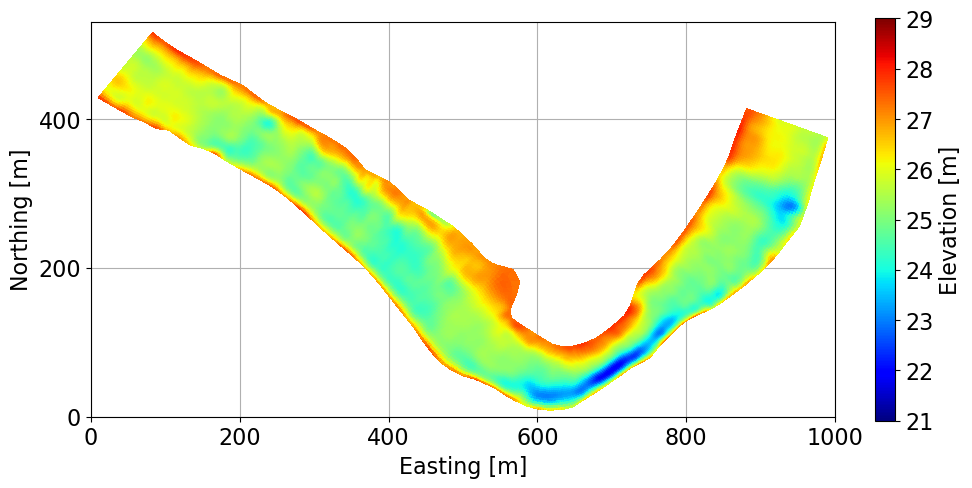

In [17]:
model_data.plt_im_tri(pred_river.ravel(), 'res.jpg', False)

Error standard deviation

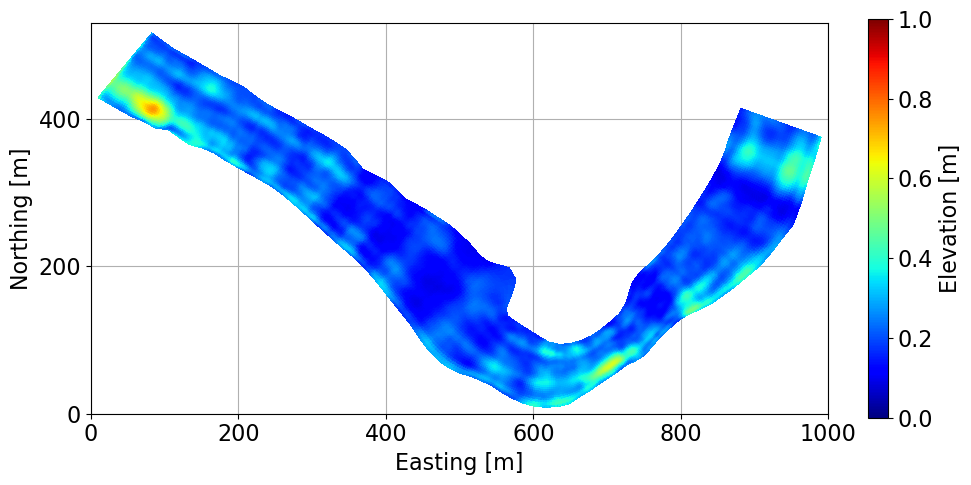

In [18]:
model_data.plt_im_tri(y_std.ravel(), 'est_std.jpg', False, 0, 1)

The reference river profile

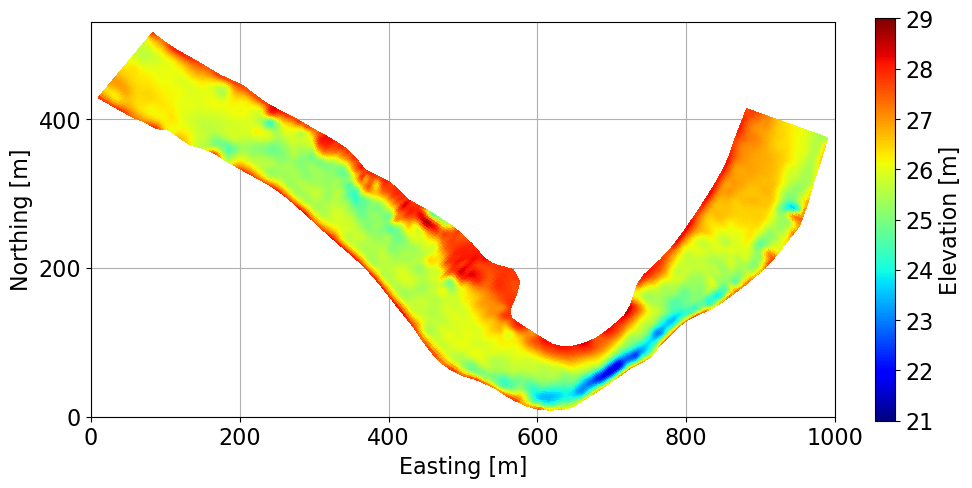

In [19]:
model_data.plt_im_tri(prof_red.ravel(), 'ref_bathy.jpg', False)